# Kaggle - Help to Protect the Great Barrier Reef

## Environment Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset downloading

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
# Obtain your kaggle.json from your profile in kaggle.com and upload it to colab
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download dataset
! kaggle competitions download -c tensorflow-great-barrier-reef

100% 14.2G/14.2G [01:10<00:00, 258MB/s]
100% 14.2G/14.2G [01:10<00:00, 215MB/s]


In [ ]:
import os
# Check current working directory
print(os.getcwd())
# Change the working directory
path = '/content/drive/MyDrive/Protect_Reef'
os.chdir(path)
print(os.getcwd())

/content
/content/drive/MyDrive/Protect_Reef


In [ ]:
# Save the data to your own drive
import shutil
shutil.copy('/content/tensorflow-great-barrier-reef.zip', '/content/drive/MyDrive/Protect_Reef')

In [ ]:
! unzip tensorflow-great-barrier-reef.zip

In [ ]:
# ! rm -rf tensorflow-great-barrier-reef.zip

### Install Libraries

In [2]:
! pip install wandb -qqq
! pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code

### Import Libraries

In [3]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys

from joblib import Parallel, delayed

from IPython.display import display

import wandb

In [4]:
# Use Weights & Biases (W&B) MLOps platform for tracking the experiments
# Log in to your W&B account
wandb.login()

wandb: Currently logged in as: erisedtang (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Metadata Setting

In [43]:
FOLD      = 1 # which fold to train
DIM       = 3000 
MODEL     = 'yolov5s6'
BATCH     = 4
EPOCHS    = 10
OPTMIZER  = 'Adam'

PROJECT   = 'great-barrier-reef-test' # w&b in yolov5
NAME      = f'{MODEL}-dim{DIM}-fold{FOLD}-epoch{EPOCHS}' # w&b for yolov5

REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/content/drive/MyDrive/Protect_Reef' # directory to save original data
IMAGE_DIR = '/content/drive/MyDrive/Protect_Reef_Process/images' # directory to save images
LABEL_DIR = '/content/drive/MyDrive/Protect_Reef_Process/labels' # directory to save labels

## Create Directory

In [6]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Path

In [7]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                      old_image_path  \
0  /content/drive/MyDrive/Protect_Reef/train_imag...   
1  /content/drive/MyDrive/Protect_Reef/train_imag...   

                                          image_path  \
0  /content/drive/MyDrive/Protect_Reef_Process/im...   
1  /content/drive/MyDrive/Protect_Reef_Process/im...   

                                          label_path  
0  /content/drive/MyDrive/Protect_Reef_Process/la...  
1  /content/drive/MyDrive/Protect_Reef_Process/la...

## Check the Number of BBOX

In [8]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


## Clean Data

In [9]:
# Only train the model using data with annotations (bbox)
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

## Write Images

In [10]:
def make_copy(row):
    shutil.copyfile(row.old_image_path, row.image_path)
    return

In [11]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

  0%|          | 0/4919 [00:00<?, ?it/s]

## Helper Function

In [12]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [13]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   
17         0     40258           17              17     0-17   

                                          annotations  \
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   
17  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]   

                                       old_image_path  \
16  /content/drive/MyDrive/Protect_Reef/train_imag...   
17  /content/drive/MyDrive/Protect_Reef/train_imag...   

                                           image_path  \
16  /content/drive/MyDrive/Protect_Reef_Process/im...   
17  /content/drive/MyDrive/Protect_Reef_Process/im...   

                                           label_path  num_bbox  \
16  /content/drive/MyDrive/Protect_Reef_Process/la...         1   
17  /content/drive/MyDrive/Protect_Reef_Process/la...         1   

                  bboxes  
16  [[559, 213, 50, 32]]  
17  [[558, 213, 50, 32]]

## Get Image Size
All images have same dimension [1280, 720].

In [14]:
df['width']  = 1280
df['height'] = 720
display(df.head(2))

video_id  sequence  video_frame  sequence_frame image_id  \
16         0     40258           16              16     0-16   
17         0     40258           17              17     0-17   

                                          annotations  \
16  [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]   
17  [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]   

                                       old_image_path  \
16  /content/drive/MyDrive/Protect_Reef/train_imag...   
17  /content/drive/MyDrive/Protect_Reef/train_imag...   

                                           image_path  \
16  /content/drive/MyDrive/Protect_Reef_Process/im...   
17  /content/drive/MyDrive/Protect_Reef_Process/im...   

                                           label_path  num_bbox  \
16  /content/drive/MyDrive/Protect_Reef_Process/la...         1   
17  /content/drive/MyDrive/Protect_Reef_Process/la...         1   

                  bboxes  width  height  
16  [[559, 213, 50, 32]]   1280     720  
17  [[558, 213, 50, 32]]   1280     720

## Create Lables

In [15]:
# Change annotations to yolo format
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = np.array([0]*num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc  = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id, row.video_id, row.sequence]]*len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print('Missing:',cnt)

  0%|          | 0/4919 [00:00<?, ?it/s]

Missing: 0


## Create Folds
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds).
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [16]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df.video_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

0    2143
1    2099
2     677
Name: fold, dtype: int64

## BBOX Distribution

In [17]:
bbox_df = pd.DataFrame(np.concatenate([bboxes_info, all_bboxes], axis=1),
             columns=['image_id','video_id','sequence',
                     'xmid','ymid','w','h'])
bbox_df[['xmid','ymid','w','h']] = bbox_df[['xmid','ymid','w','h']].astype(float)
bbox_df['area'] = bbox_df.w * bbox_df.h * 1280 * 720
bbox_df = bbox_df.merge(df[['image_id','fold']], on='image_id', how='left')
bbox_df.head(2)

image_id video_id sequence      xmid      ymid         w         h  \
0     0-16        0    40258  0.456250  0.318056  0.039062  0.044444   
1     0-17        0    40258  0.455469  0.318056  0.039062  0.044444   

         area  fold  
0  1600.00092     0  
1  1600.00092     0

### X Center V.S. Y Center

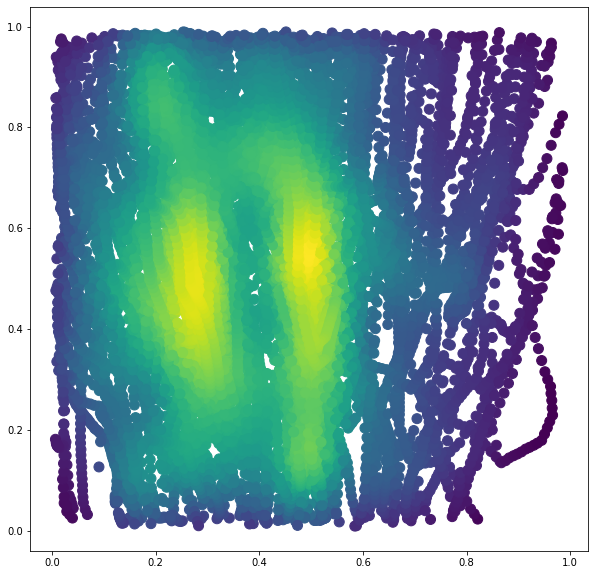

In [18]:
from scipy.stats import gaussian_kde

all_bboxes = np.array(all_bboxes)

x_val = all_bboxes[...,0]
y_val = all_bboxes[...,1]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

### Width V.S. Height

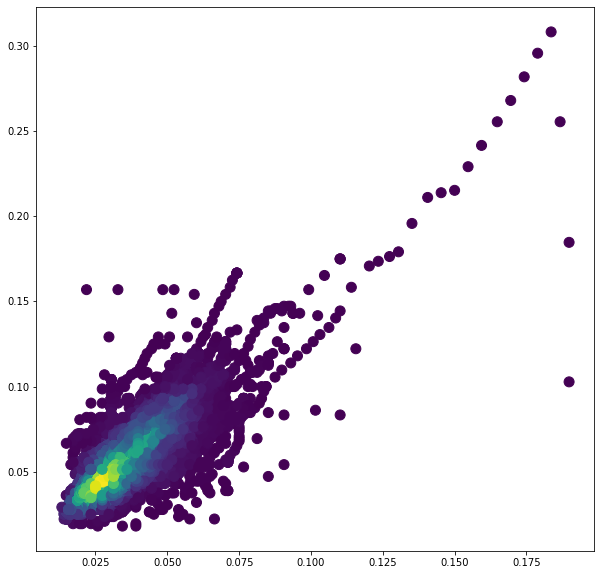

In [19]:
x_val = all_bboxes[...,2]
y_val = all_bboxes[...,3]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

### Area

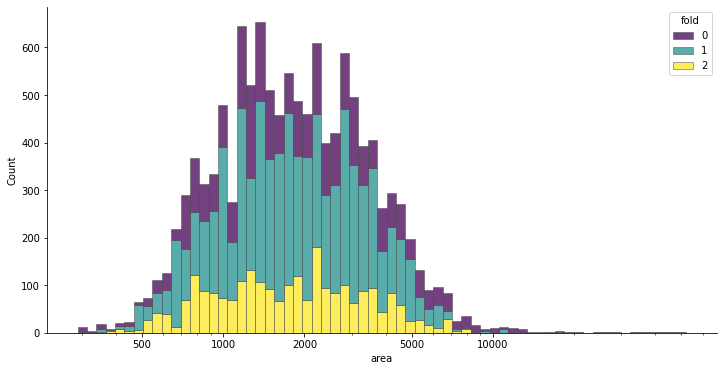

In [20]:
import matplotlib as mpl
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)

sns.histplot(
    bbox_df,
    x="area", hue="fold",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([500, 1000, 2000, 5000, 10000]);

## Data Visulization

In [21]:
df2 = df[(df.num_bbox>0)].sample(100) # takes samples with bbox
y = 3; x = 2
plt.figure(figsize=(12.8*x, 7.2*y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['cots']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Dataset Split

In [22]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(2820, 2099)

## Configuration
The dataset config file requires:

1. The dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths)
2. The number of classes nc and
3. A list of class names:['cots']

In [25]:
import os
# Check current working directory
print(os.getcwd())
# Change the working directory
path = '/content/drive/MyDrive/Protect_Reef_Model'
os.chdir(path)
print(os.getcwd())

/content
/content/drive/MyDrive/Protect_Reef_Model


In [26]:
import yaml

cwd = '/content/drive/MyDrive/Protect_Reef_Model'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = '/content/drive/MyDrive/Protect_Reef_Model',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'gbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'gbr.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- cots
nc: 1
path: /content/drive/MyDrive/Protect_Reef_Model
train: /content/drive/MyDrive/Protect_Reef_Model/train.txt
val: /content/drive/MyDrive/Protect_Reef_Model/val.txt



In [27]:
%%writefile /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml
lr0: 0.001  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.5  # image mosaic (probability)
mixup: 0.5 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Writing /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml


## YOLOv5 Setting

In [46]:
os.chdir('/content')
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.9/166.8 GB disk)


## Model Training

In [47]:
!python train.py --img {DIM} --batch {BATCH} --epochs {EPOCHS} --optimizer {OPTMIZER} --data /content/drive/MyDrive/Protect_Reef_Model/gbr.yaml --hyp /content/drive/MyDrive/Protect_Reef_Model/hyp.yaml --weights {MODEL}.pt --project {PROJECT} --name {NAME} --exist-ok


wandb: Currently logged in as: erisedtang (use `wandb login --relogin` to force relogin)
train: weights=yolov5s6.pt, cfg=, data=/content/drive/MyDrive/Protect_Reef_Model/gbr.yaml, hyp=/content/drive/MyDrive/Protect_Reef_Model/hyp.yaml, epochs=10, batch_size=4, imgsz=3000, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=great-barrier-reef-test, name=yolov5s6-dim3000-fold1-epoch10, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-135-g7926afc torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.001, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, war

## Output File

In [48]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)
!ls {OUTPUT_DIR}

confusion_matrix.png				    results.png
events.out.tfevents.1650258862.f36dc0de2cea.6701.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


### Class Distribution

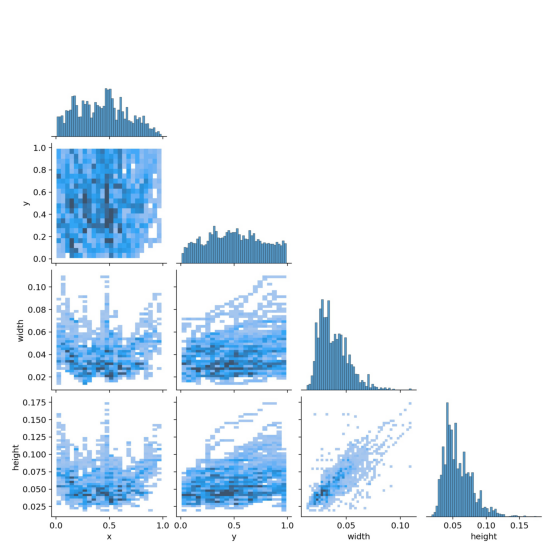

In [49]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels_correlogram.jpg'));

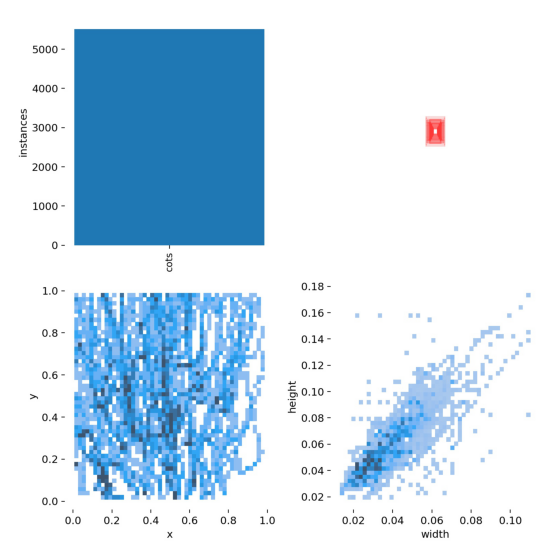

In [50]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels.jpg'));

### Batch Image

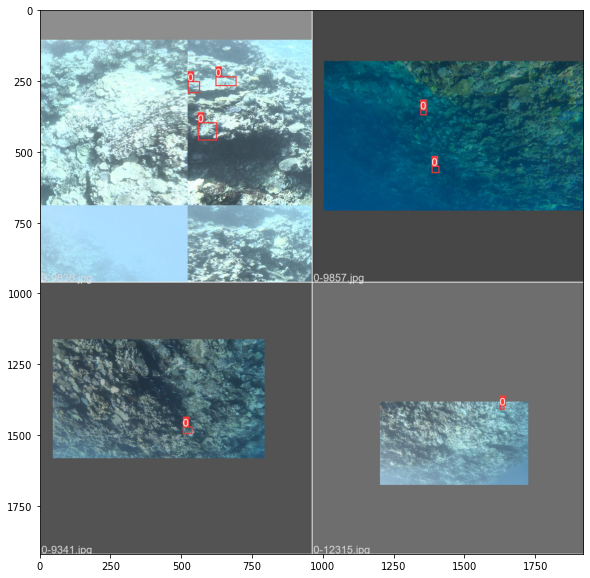

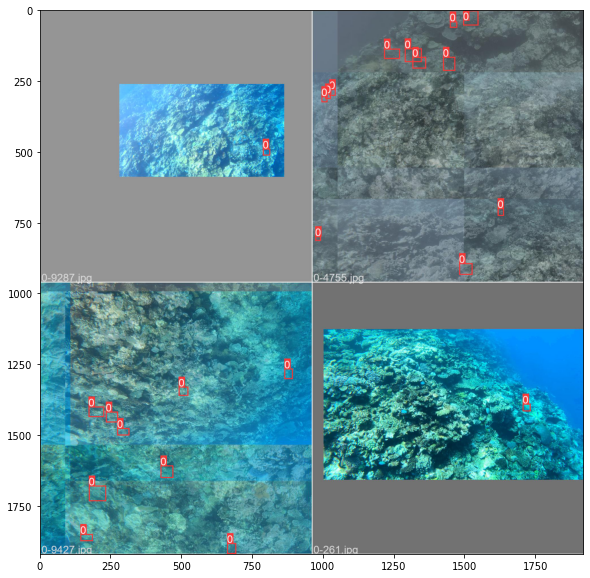

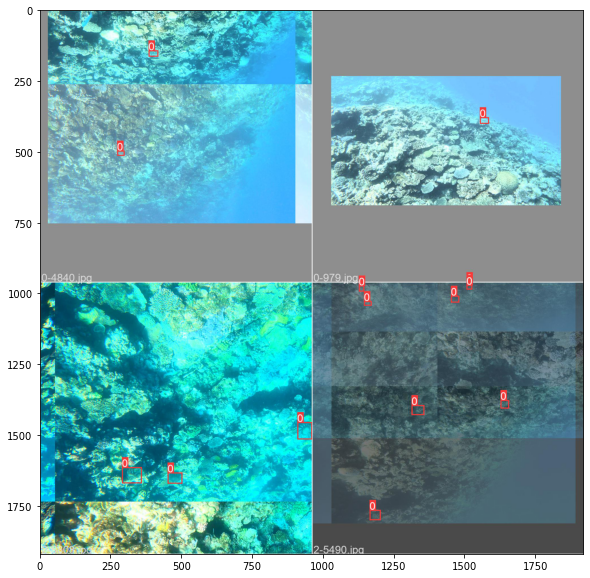

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch2.jpg'))

### Ground True VS Predict

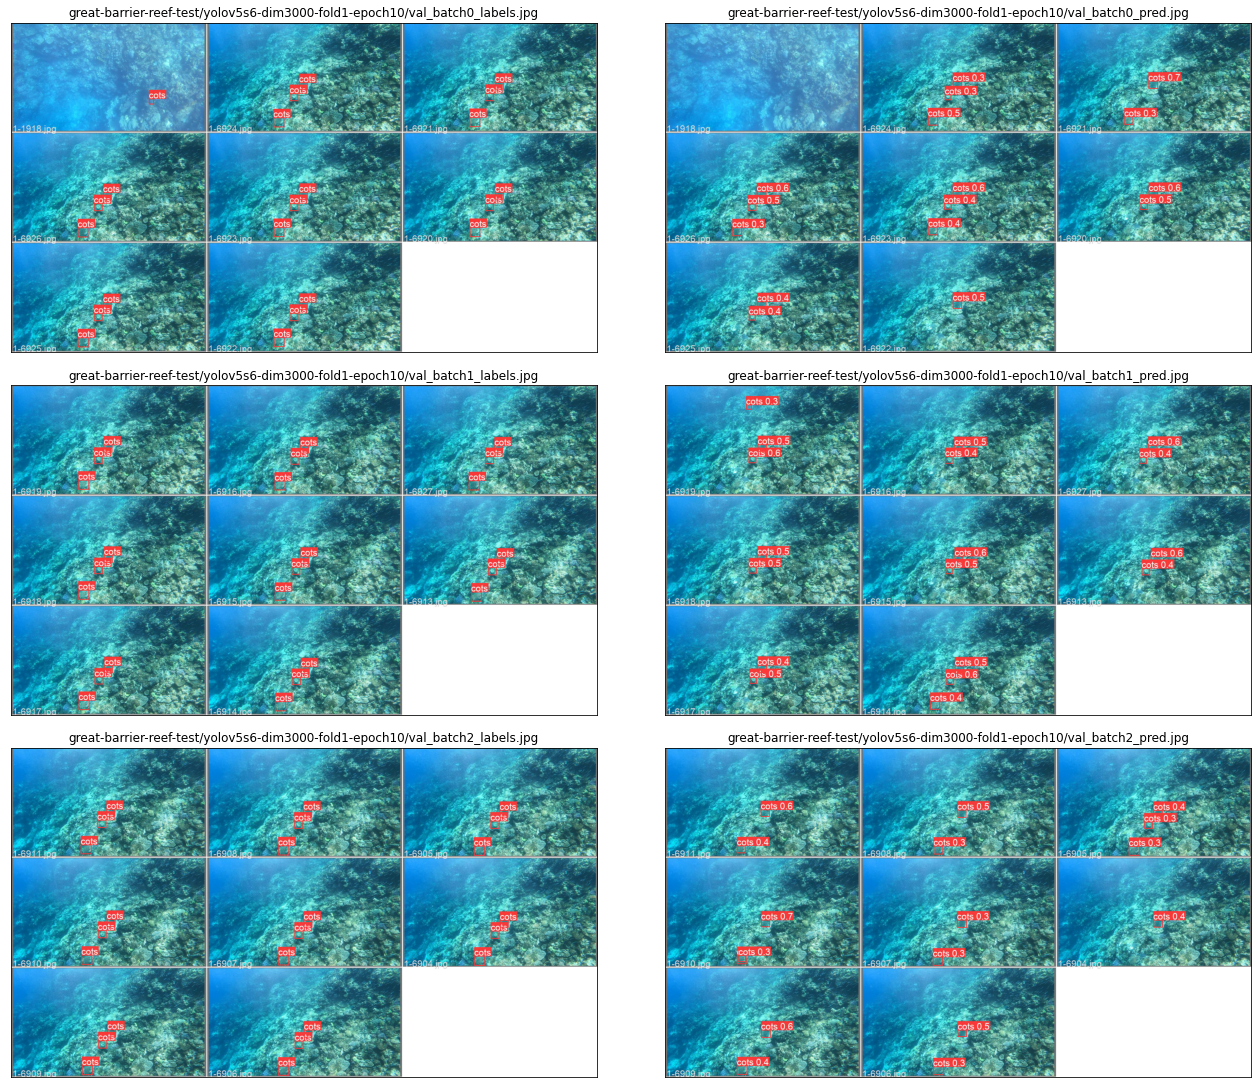

In [52]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

## Result

### Score VS Epoch

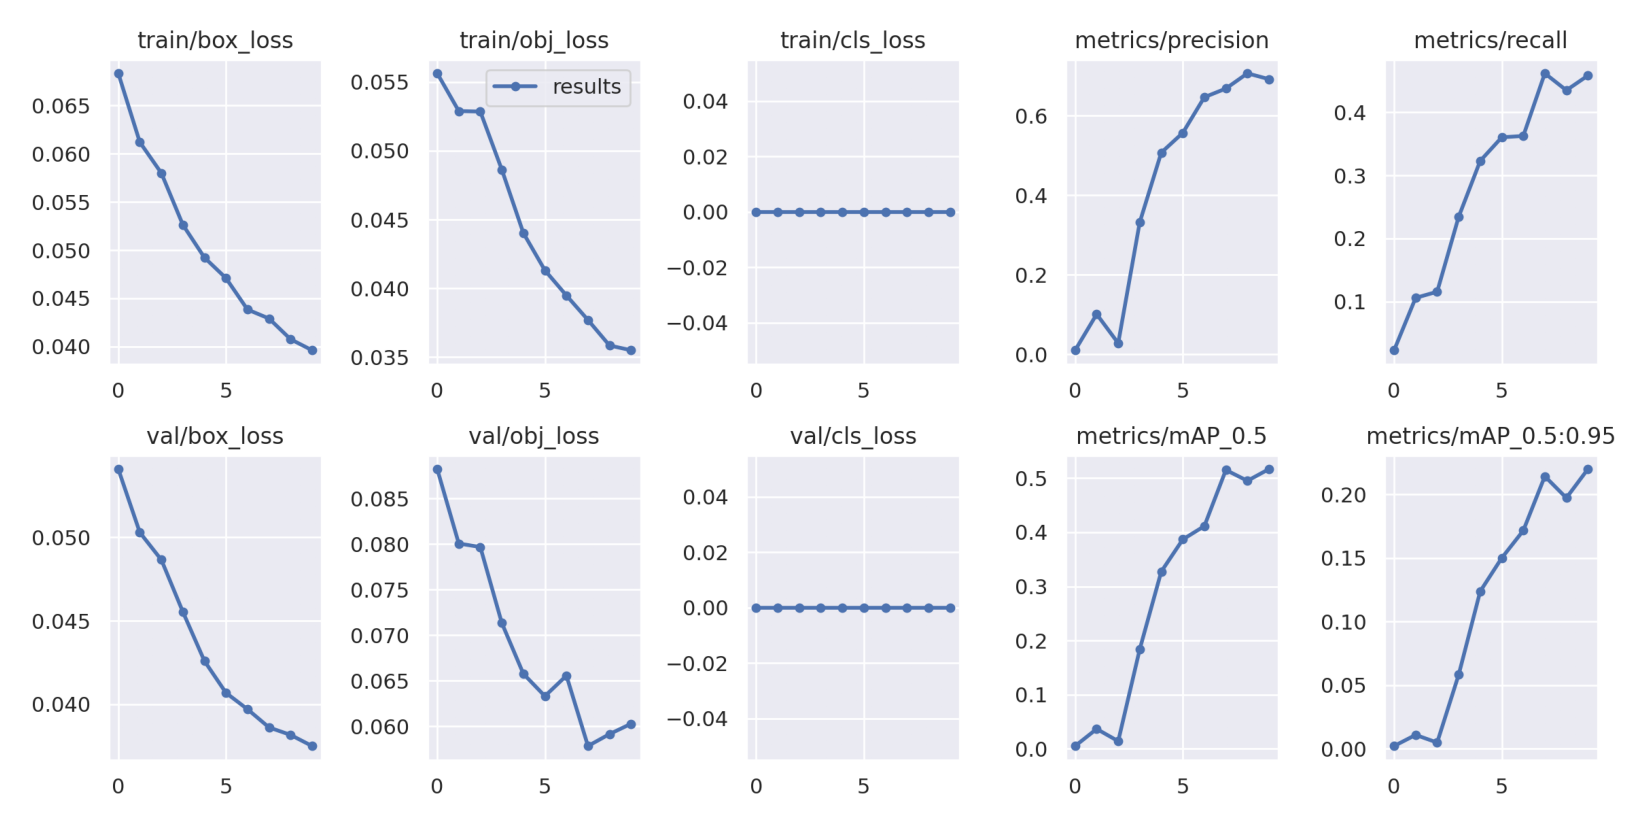

In [53]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

### Confusion Matrix

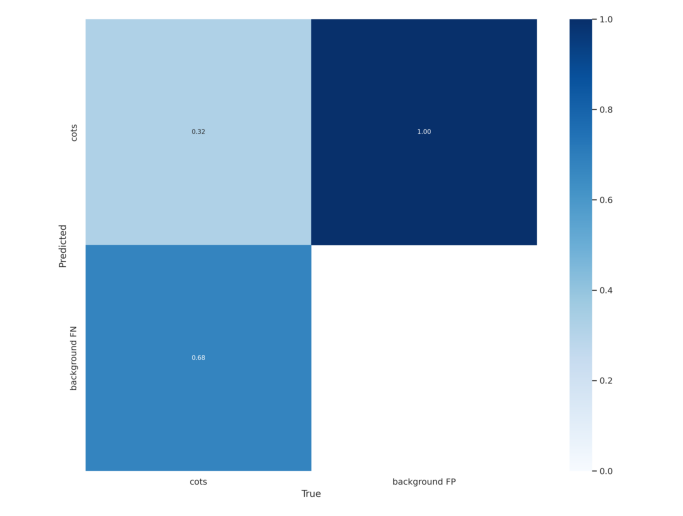

In [54]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

### Metrics

Metric: F1


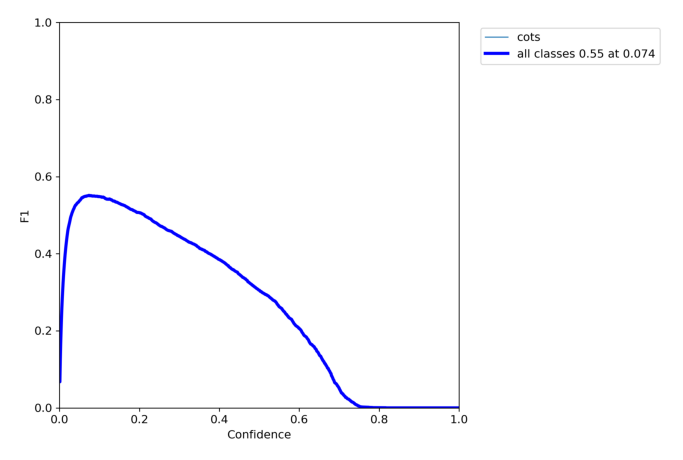

Metric: PR


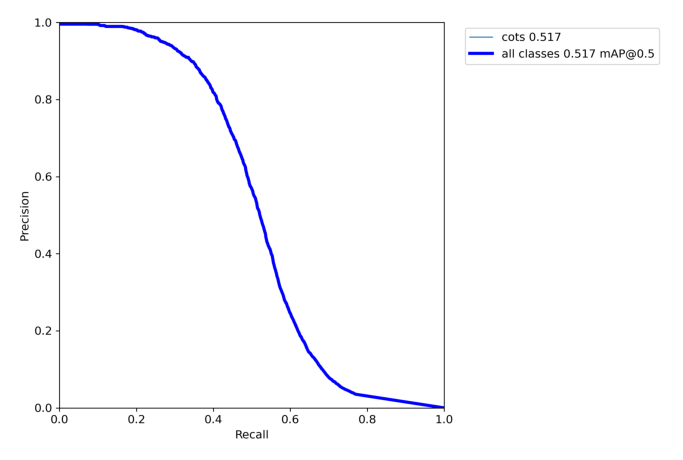

Metric: P


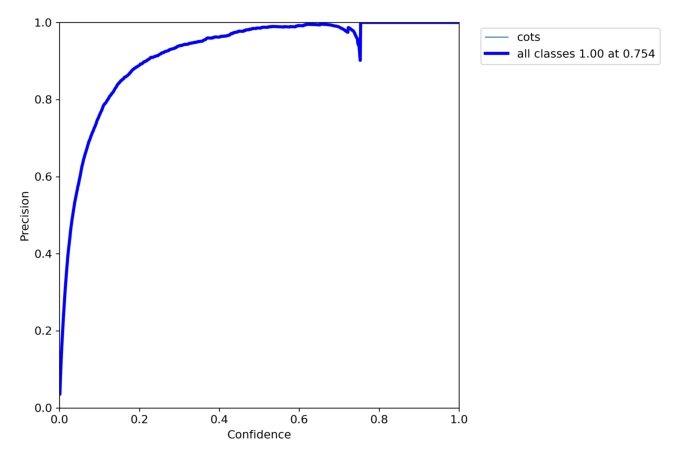

Metric: R


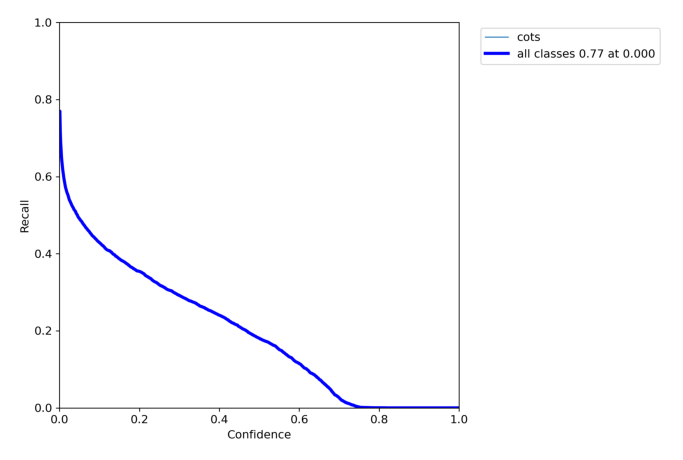

In [55]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'));
    plt.show()